# Notebook for the Alento (site nb2) data processing

- 🔨 Data acquisition: G. Cassiani
- Notebook Author: B. Mary

### Steps to reproduce
- import all libraries
- import raw merged data 
- create resipy project 3d
- import electrode geometry
- create thetra mesh
- invert
- show results 

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Dec  6 09:22:55 2021

@author: ben
"""
# import resipy and other useful libraries
# -----------------------------------------------------------------------------
#get_ipython().run_line_magic('matplotlib', 'inline')
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyvista as pv

import ipywidgets

In [2]:
#!pip install resipy==3.3.2

In [2]:
correct_topo = 1
per_rec = 10 #10

In [4]:
sys.path.append((os.path.relpath('../src'))) # add here the relative path of the API folder
from resipy import Project

API path =  /home/ben/miniconda3/lib/python3.9/site-packages/resipy
ResIPy version =  3.3.2
cR2.exe found and up to date.
R3t.exe found and up to date.
cR3t.exe found and up to date.


In [5]:
regMode = 1
dir_simu = '../INV/timeLapse/TL2b3456' + 'regMode' + str(regMode)
k = Project(dirname=dir_simu, typ='R3t')
k.setTitle('Salorno_site2')

Working directory is: /home/ben/Documents/GitHub/BenjMy/Salorno_river/INV/timeLapse/TL2b3456regMode1
clearing dirname


# Set reciprocal filter to 10%

In [6]:
print(os.getcwd())

import pandas

filenames = [
            '../rawData/file120data1.dat',
            '../rawData/file120data2.dat',
            '../rawData/file120data3.dat',
            '../rawData/file120data4.dat',
            '../rawData/file120data5.dat',
            '../rawData/file120data6.dat',
            ]

/home/ben/Documents/GitHub/BenjMy/Salorno_river/notebooks


In [7]:
# import raw data and reshape for resipy 
# -----------------------------------------------------------------------------
#data = np.loadtxt('../rawData/file120data.dat')

#data_df = pd.DataFrame(data[:,[0,1,2,3,8,9]], columns=['Spa.1','Spa.2','Spa.3','Spa.4','Vp' ,'In'])
#data_df['Spa.1'] = data_df['Spa.1'].astype(int)
#data_df['Spa.2'] =data_df['Spa.2'].astype(int)
#data_df['Spa.3'] =data_df['Spa.3'].astype(int)
#data_df['Spa.4'] = data_df['Spa.4'].astype(int)

#data_df['dev'] = np.zeros(len(data_df['Spa.1']))
#data_df.to_csv('./file120data.csv', index=False)

#data_df.head()


In [8]:
column_names = ['Spa.1','Spa.2','Spa.3','Spa.4','Vp','In']
idx = [0,1,2,3,8,9]
filenames_csv = []
for f in filenames:
    numpyfile = np.loadtxt(f, skiprows=1)
    df=pd.DataFrame(numpyfile[:,idx],columns=column_names)
    df['dev']=np.zeros(len(df['Spa.1']))
    df = df.astype({"Spa.1": int}) 
    df = df.astype({"Spa.2": int}) 
    df = df.astype({"Spa.3": int}) 
    df = df.astype({"Spa.4": int}) 
    filenames_csv.append(f + '.csv')
    df.to_csv(f + '.csv',sep=',',index=False)

In [9]:
filenames_csv

['../rawData/file120data1.dat.csv',
 '../rawData/file120data2.dat.csv',
 '../rawData/file120data3.dat.csv',
 '../rawData/file120data4.dat.csv',
 '../rawData/file120data5.dat.csv',
 '../rawData/file120data6.dat.csv']

In [10]:
# create survey
# -----------------------------------------------------------------------------
print(os.getcwd())
k.createTimeLapseSurvey(filenames_csv,
                         ftype='Syscal')
k.filterRecip(index=-1, percent=per_rec)

/home/ben/Documents/GitHub/BenjMy/Salorno_river/notebooks
6/6 imported
9542 measurements with greater than 10.0% reciprocal error removed!
10528 measurements with greater than 10.0% reciprocal error removed!
10208 measurements with greater than 10.0% reciprocal error removed!
10186 measurements with greater than 10.0% reciprocal error removed!
9875 measurements with greater than 10.0% reciprocal error removed!
10232 measurements with greater than 10.0% reciprocal error removed!


60571

# Create boreholes geometry

### raw file: coordinatepozzilaghetti.txt

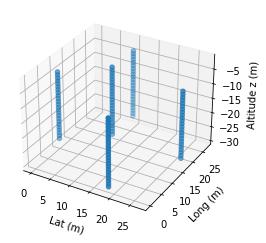

,x,y,z,label,buried
0,0.0,9.8939,-27.5045,1,True
1,0.0,9.8939,-26.5045,2,True
2,0.0,9.8939,-25.5045,3,True
3,0.0,9.8939,-24.5045,4,True
4,0.0,9.8939,-23.5045,5,True


In [11]:
# create boreholes geometry
# -----------------------------------------------------------------------------
nb_elecs_bor = 24
elecs_spacing = 1
offset = 1
asc_bor = np.arange(-nb_elecs_bor*elecs_spacing-offset,0-offset)
des_bor = np.flip(asc_bor)
elecs_z = np.hstack([asc_bor,des_bor,des_bor,des_bor,des_bor])

elecs = []
label = []

# lat/long of the electrodes
# -----------------------------------------------------------------------------
pozzi_coords = pd.read_csv('../survey/coordinatepozzilaghetti.txt', header='infer')

# lat/long to absolute positions
# -----------------------------------------------------------------------------
pozzi_coords['x'] = pozzi_coords['x'] - min(pozzi_coords['x'])
pozzi_coords['y'] = pozzi_coords['y'] - min(pozzi_coords['y'])
pozzi_coords['z'] = pozzi_coords['z'] - max(pozzi_coords['z'])


i=1
for index, row in pozzi_coords.iterrows():
    for ne in range(len(asc_bor)):
        elecs.append([row[1],row[2],row[3]])
        # print([str(1),str((ne+1)*(index+1))])
        # label.append(' '.join([str(index+1),str(ne+1)]))
        # label.append(' '.join([str(1),str(i)]))
        label.append(' '.join([str(i)]))
        i +=1

# correct for altitude
# -----------------------------------------------------------------------------
for ze in enumerate(elecs_z):
    # print(ze)
    if correct_topo == 1:
        elecs[ze[0]][2] +=  ze[1]
    else:
        elecs[ze[0]][2] =  ze[1]

elecs = np.vstack(elecs)

if correct_topo == 1:
    max_elecs = pozzi_coords['z'] - 2
else:
    max_elecs= max(elecs[:,2])

# buried flag for upper surface electrode is False!
# -----------------------------------------------------------------------------
buried = []
for e in elecs:
    if (round(e[2],4) == round(max_elecs, 4)).any():
        buried.append(False)
    else:
        buried.append(True)
            
# plot electrode positions
# -----------------------------------------------------------------------------
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(elecs[:,0], elecs[:,1], elecs[:,2], marker='o')

ax.set_xlabel('Lat (m)')
ax.set_ylabel('Long (m)')
ax.set_zlabel('Altitude z (m)')

plt.show()

# electrode positions to dataframe
# -----------------------------------------------------------------------------
elecs_df = pd.DataFrame(elecs,columns=['x', 'y', 'z'])
elecs_df['label'] = label
elecs_df['buried'] = buried

elecs_df.to_csv('./elecs120data.csv', index=False)
elecs_df.head()

Creating tetrahedral mesh...done (12111 elements)


/home/ben/miniconda3/lib/python3.9/site-packages/vtkmodules/util/numpy_support.py:74: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  _vtk_np = {vtkConstants.VTK_BIT:numpy.bool,


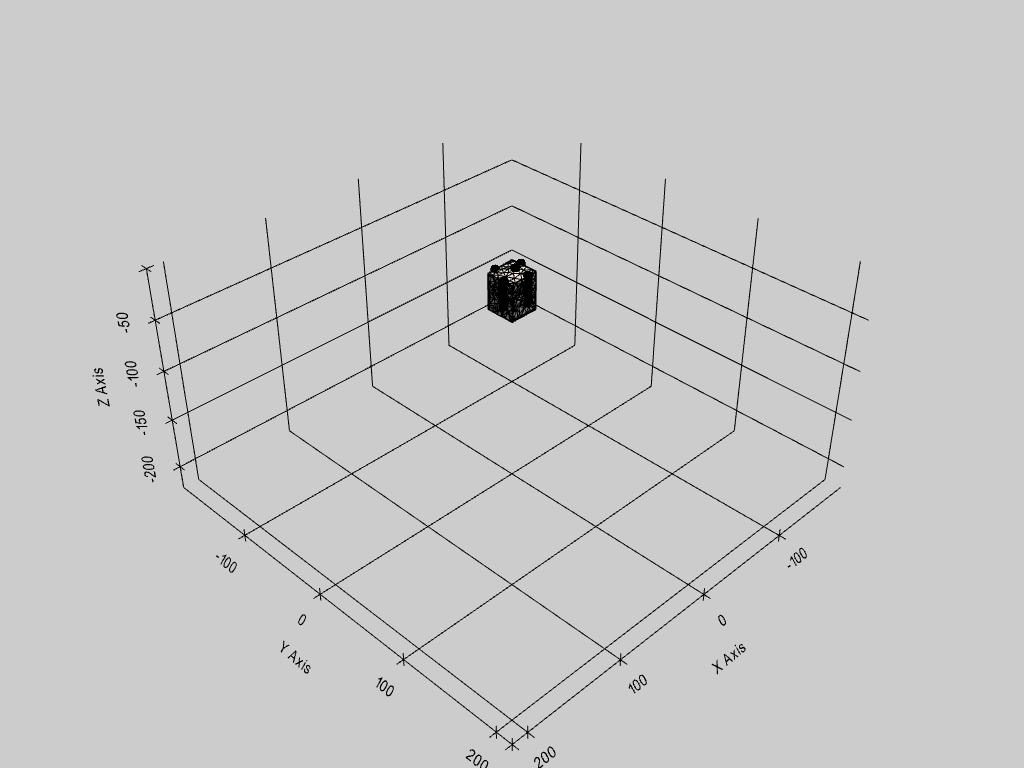

In [12]:
k.setElec(elecs_df)
k.createMesh(refine=0)
k.showMesh()
             # cl_factor=8.00, 
             # cln_factor=100.00,

# Inversion

In [0]:
# inversion
# -----------------------------------------------------------------------------
k.param['num_xy_poly'] = 0
k.param['z_min'] = -np.inf
k.param['z_max'] = np.inf

# k.param['z_min'] = max(elecs_df['z'])
# k.param['z_max'] = min(elecs_df['z'])
k.param['data_type'] = 1 # using log of resistitivy
k.err = False # if we want to use the error from the error models fitted before
k.param['a_wgt'] = 0.01
k.param['b_wgt'] = per_rec/100 #0.05
k.param['reg_mode'] = regMode
k.invert() # this will do the inversion
# k.saveData(MainPath)

Writing .in file and protocol.dat... Matching quadrupoles between surveys for difference inversion...7604 in common...done in 0.089942s
done
------------ INVERTING REFERENCE SURVEY ---------------


 >> R 3 t     E R T    M o d e l    v 2.31 <<

 >> Date: 16-05-2022
 >> Salorno_site_TL12                                                               
 >> I n v e r s e   S o l u t i o n   S e l e c t e d <<
 >> A d v a n c e d   M e s h   I n p u t <<
 >> T e t r a h e d r a l   E l e m e n t   M e s h <<

 >> Reading mesh file 
 >> Determining storage needed for finite element conductance matrix
 >> Generating index array for finite element conductance matrix
 >> Reading resistivity model from res0.dat                                                                        

 >> L o g - D a t a   I n v e r s i o n <<
 >> N o r m a l   R e g u l a r i s a t i o n <<

 >> Memory estimates:
    For   1000 measurements the memory needed is:          0.101 Gb
    For   2000 measurements the m

0338:fixme:ver:GetCurrentPackageId (000000000011EB10 0000000000000000): stub


Writing .in file and mesh.dat... done
Writing protocol.dat... done
Running forward model... 

 >> R 3 t     E R T    M o d e l    v 2.31 <<

 >> Date: 16-05-2022
 >> Salorno_site_TL12                                                               
 >> F o r w a r d   S o l u t i o n   S e l e c t e d <<
 >> A d v a n c e d   M e s h   I n p u t <<
 >> T e t r a h e d r a l   E l e m e n t   M e s h <<

 >> Reading mesh file 
 >> Determining storage needed for finite element conductance matrix
 >> Generating index array for finite element conductance matrix
 >> Reading resistivity model from resistivity.dat                                                                 

 >> Memory estimates:
    For   1000 measurements the memory needed is:          0.003 Gb
    For   2000 measurements the memory needed is:          0.003 Gb
    For   5000 measurements the memory needed is:          0.003 Gb
    For  10000 measurements the memory needed is:          0.003 Gb

 >> Number of measurements

0348:fixme:ver:GetCurrentPackageId (000000000011EB10 0000000000000000): stub


8993/9677 reciprocal measurements found.
0 measurements error > 20 %
Forward modelling done.Matching quadrupoles between surveys for difference inversion...7604 in common...done in 0.16619s

--------------------- MAIN INVERSION ------------------


 >> R 3 t     E R T    M o d e l    v 2.31 <<

 >> Date: 16-05-2022
 >> Salorno_site_TL12                                                               
 >> I n v e r s e   S o l u t i o n   S e l e c t e d <<
 >> A d v a n c e d   M e s h   I n p u t <<
 >> T e t r a h e d r a l   E l e m e n t   M e s h <<

 >> Reading mesh file 
 >> Determining storage needed for finite element conductance matrix
 >> Generating index array for finite element conductance matrix
 >> Reading resistivity model from Start_res.dat                                                                   

 >> L o g - D a t a   I n v e r s i o n <<
 >> D i f f e r e n c e   R e g u l a r i s a t i o n <<

 >> Memory estimates:
    For   1000 measurements the memory need

In [0]:
# save project
# -----------------------------------------------------------------------------
k.saveProject('Salorno_TL12')

# Results

In [0]:
#pl = pv.Plotter()
#mesh = pv.read(k.dirname + '/f001_res.vtk')
#pl.add_mesh(mesh)
#pl.show()
# https://hkex.gitlab.io/resipy/auto_examples/nb_3d-time-lapse.html


In [0]:
k.showResults(index = 0,
              attr='Resistivity(log10)', 
              sens=True, 
              contour=True, 
              use_pyvista=True,
              color_map='jet',zlim=[-30,0],
              background_color='white')

In [0]:
pl = pv.Plotter()
k.showResults(index = 0,
              attr='Resistivity(ohm.m)',
              ax=pl, pvslices=([5,15,25],[15],[]), 
              pvgrid=True, 
              vmin=0, 
              vmax=300, 
              color_map='jet',zlim=[-30,0],
              background_color='white')

In [0]:
pl = pv.Plotter()
k.showResults(
              attr='Resistivity(ohm.m)',
              ax=pl, pvthreshold=[0,75], pvgrid=True,zlim=[-30,0],
              background_color='white')

In [0]:
k.showResults(index=1, 
    attr='difference(percent)', 
    contour=False, vmin=0, vmax=100)

In [0]:
k.showResults(index=2, 
    attr='difference(percent)', 
    contour=False, vmin=0, vmax=100)

In [0]:
k.showResults(index=3, 
    attr='difference(percent)', 
    contour=False, vmin=0, vmax=100)

In [0]:
k.showResults(index=4, 
    attr='difference(percent)', 
    contour=False, vmin=0, vmax=100)

In [0]:
k.showResults(index=5, 
    attr='difference(percent)', 
    contour=False, vmin=0, vmax=100)